In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from numpy.random import seed
seed(42)
import tensorflow
tensorflow.random.set_seed(42)

In [3]:
import numpy as np
import pandas as pd
import util.common as util
from tensorflow import keras

# Load Data

In [50]:
clean_dir = "/project/data/cicids2017/clean/"
x_binary_train, y_binary_train, x_binary_val, y_binary_val, x_binary_test, y_binary_test, x_multi_train, y_multi_train, x_multi_test, y_multi_test = util.load_data(clean_dir, train_size=100000, sample_size=1948)

(D)DOS          321637
Port Scan        90694
Brute Force       9150
Web Attack        2143
Botnet            1948
Infiltration        36
Heartbleed          11
Name: Label, dtype: int64
Attack type:    #Original:     #Sampled:      #Train:       #Test:
      (D)DOS        321637          1948         1363          585
      Botnet          1948          1948         1363          585
 Brute Force          9150          1948         1363          585
  Heartbleed            11            11            0           11
Infiltration            36            36            0           36
   Port Scan         90694          1948         1363          585
  Web Attack          2143          1948         1363          585


In [174]:
x_train = x_multi_train
y_train = y_multi_train
# x_test = np.concatenate((x_binary_train[-585:], x_multi_test))
# y_test = np.concatenate((np.full(585, "Benign"), y_multi_test))
x_test = x_multi_test
y_test = y_multi_test
y_test[y_test == "Heartbleed"] = "Unknown"
y_test[y_test == "Infiltration"] = "Unknown"

In [175]:
np.unique(y_train, return_counts=True)

(array(['(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Web Attack'],
       dtype=object),
 array([1363, 1363, 1363, 1363, 1363]))

In [176]:
np.unique(y_test, return_counts=True)

(array(['(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Unknown',
        'Web Attack'], dtype=object),
 array([585, 585, 585, 585,  47, 585]))

# Rescale Data

In [177]:
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, MinMaxScaler

binary_scaler = QuantileTransformer(output_distribution='normal')
x_binary_train_s = binary_scaler.fit_transform(x_binary_train)
x_binary_val_s = binary_scaler.transform(x_binary_val)
x_train_1 = binary_scaler.transform(x_train)
x_test_1 = binary_scaler.transform(x_test)

# Load Binary Model

In [55]:
study_name = "TWOS-37"
trial_number = 1223
path = f'results/binary/autoencoder/{study_name}/models/model_{trial_number}.h5'

In [56]:
model = keras.models.load_model(path)
print(model.summary())

Model: "model_305"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_306 (InputLayer)       [(None, 67)]              0         
_________________________________________________________________
dense_1322 (Dense)           (None, 66)                4488      
_________________________________________________________________
dense_1323 (Dense)           (None, 63)                4221      
_________________________________________________________________
dense_1324 (Dense)           (None, 66)                4224      
_________________________________________________________________
dense_1325 (Dense)           (None, 67)                4489      
Total params: 17,422
Trainable params: 17,422
Non-trainable params: 0
_________________________________________________________________
None


In [178]:
# Sanity Check
x = x_binary_val_s
y = y_binary_val
x_predict = model.predict(x)
score = util.anomaly_scores(x, x_predict)
metrics = util.evaluate_results(y, score)
metrics

/project/Two-Stage/util/common.py:99: RuntimeWarning: invalid value encountered in true_divide
  results["f1"] = 2*precision*recall/(precision+recall)
/project/Two-Stage/util/common.py:100: RuntimeWarning: invalid value encountered in true_divide
  results["f2"] = 5*precision*recall/(4*precision+recall)


f1                   precision     0.301306
                     recall        0.758327
                     f1            0.431260
                     f2            0.581825
f2                   precision     0.289229
                     recall        0.802201
                     f1            0.425166
                     f2            0.592154
f1threshold                       17.202332
f2threshold                       16.121395
au_precision_recall                0.318725
auroc                              0.907273
dtype: float64

In [185]:
threshold = metrics['f2threshold'][0]

In [186]:
x_predict = model.predict(x_train_1)
score_train = util.anomaly_scores(x_train_1, x_predict)

In [187]:
y_pred = np.where(score_train < threshold, 1, -1)
print(f"pred: fraud({sum(y_pred == -1)}), benign({sum(y_pred == 1)})")

pred: fraud(5467), benign(1348)


In [188]:
x_predict = model.predict(x_test_1)
score_test = util.anomaly_scores(x_test_1, x_predict)

In [189]:
y_pred = np.where(score_test < threshold, 1, -1)
print(f"pred: fraud({sum(y_pred == -1)}), benign({sum(y_pred == 1)})")

pred: fraud(2190), benign(782)


## Concat Anomaly Score as Feature

In [190]:
x_train_2 = np.column_stack((x_train, score_train))
x_test_2 = np.column_stack((x_test, score_test))

In [191]:
scalers = {
    'standard': StandardScaler(),
    'robust': RobustScaler(quantile_range=(25, 75)),
    'quantile': QuantileTransformer(output_distribution='normal'),
    'minmax': MinMaxScaler(feature_range=(0, 1), copy=True)
}
x_train_s = {}
x_test_s = {}
for key, value in scalers.items():
    x_train_s[key] = value.fit_transform(x_train_2)
    x_test_s[key] = value.transform(x_test_2)

# Train Multi-Class model

In [87]:
from sklearn.ensemble import RandomForestClassifier

In [237]:
scaler = "minmax"
params = {'max_samples': 0.852098, 'max_features': 0.707293, 'min_samples_leaf': 1}

forest = RandomForestClassifier(random_state=42, oob_score=True)
# forest.set_params(**params)
forest.fit(x_train_s[scaler], y_train)

RandomForestClassifier(oob_score=True, random_state=42)

In [238]:
y_proba = forest.predict_proba(x_test_s[scaler])
forest.oob_score_

0.9985326485693323

## Find Optimal Threshold

In [208]:
from sklearn.metrics import f1_score
from tqdm import tqdm

thresholds = np.arange(0.0, 1.0, 0.005)
fscore = np.zeros(shape=(len(thresholds)))

# Fit the model
for index, threshold in tqdm(enumerate(thresholds)):
    # Corrected probabilities
    y_pred = np.where(np.max(y_proba, axis=1) > threshold, forest.classes_[np.argmax(y_proba, axis=1)], 'Unknown')
    # Calculate the f-score
    fscore[index] = f1_score(y_test, y_pred, average='macro', labels=['(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Web Attack'])

# Find the optimal threshold
index = np.argmax(fscore)
thresholdOpt = round(thresholds[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))

200it [00:04, 49.91it/s]

Best Threshold: 0.915 with F-Score: 0.8616


In [220]:
threshold = thresholdOpt
y_pred = np.where(np.max(y_proba, axis=1) > threshold, forest.classes_[np.argmax(y_proba, axis=1)], 'Unknown')

/project/Two-Stage/util/common.py:114: RuntimeWarning: invalid value encountered in true_divide
  cm_perc = cm / cm_sum.astype(float)


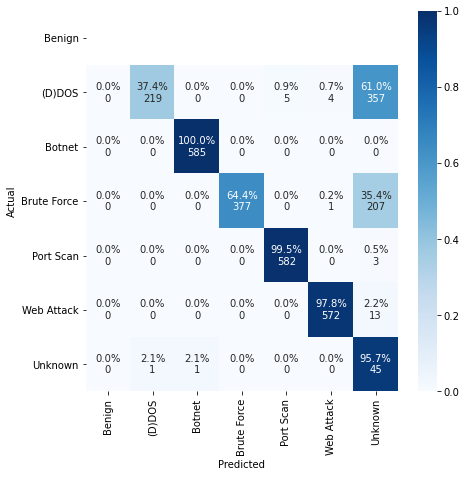

In [221]:
classes = ['Benign', '(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Web Attack', 'Unknown']
fig = util.plot_confusion_matrix(y_test, y_pred, values=classes, labels=classes)

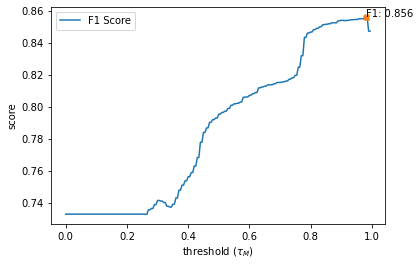

In [148]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(thresholds, fscore, label="F1 Score")
plt.plot(thresholdOpt, fscoreOpt, marker="X")
plt.annotate(f"F1: {str(round(fscoreOpt, 3))}", (thresholdOpt, fscoreOpt))
plt.xlabel(r"threshold ($\tau_M$)")
plt.ylabel("score")
plt.legend()

In [154]:
import optuna

In [166]:
study_storage = 'results/multi/randomforest-multi.db'

In [167]:
list(map(lambda s: s.study_name, optuna.study.get_all_study_summaries(storage=f"sqlite:///{study_storage}")))

['TWOS-37']

In [168]:
study_name = "TWOS-37"
save_dir = f'results/multi/randomforest/{study_name}'

In [169]:
study = optuna.load_study(study_name=study_name, storage=f"sqlite:///{study_storage}")
results = study.trials_dataframe()
results.sort_values(by=['value'], inplace=True, ascending=False)
# results.to_csv(f'{save_dir}/result.csv')
results.head()

,number,value,datetime_start,datetime_complete,duration,params_max_features,params_max_samples,params_min_samples_leaf,params_scaler,user_attrs_OOB,user_attrs_f1scoreOptimal,user_attrs_thresholdOptimal,state
217,217,0.999120,2021-03-08 23:45:11.559389,2021-03-08 23:52:13.726508,0 days 00:07:02.167119,0.707293,0.852098,1,minmax,0.999120,0.739774,0.92,COMPLETE
271,271,0.998973,2021-03-08 23:54:12.664483,2021-03-09 00:00:27.238069,0 days 00:06:14.573586,0.633625,0.587027,1,quantile,0.998973,0.737887,0.91,COMPLETE
265,265,0.998973,2021-03-08 23:53:46.769867,2021-03-09 00:00:34.042779,0 days 00:06:47.272912,0.591672,0.602038,1,quantile,0.998973,0.738029,0.92,COMPLETE
284,284,0.998826,2021-03-08 23:57:12.527286,2021-03-09 00:02:25.071847,0 days 00:05:12.544561,0.601246,0.967046,2,minmax,0.998826,0.740380,0.92,COMPLETE
219,219,0.998826,2021-03-08 23:45:29.557304,2021-03-08 23:52:25.619285,0 days 00:06:56.061981,0.609597,0.625706,1,minmax,0.998826,0.739637,0.89,COMPLETE


In [247]:
results.sort_values(by=['user_attrs_f1scoreOptimal'], ascending=False).iloc[0]

number                                                113
value                                            0.952164
datetime_start                 2021-03-08 23:25:31.279626
datetime_complete              2021-03-08 23:30:05.608264
duration                           0 days 00:04:34.328638
params_max_features                               0.09099
params_max_samples                               0.130354
params_min_samples_leaf                                99
params_scaler                                    quantile
user_attrs_OOB                                   0.952164
user_attrs_f1scoreOptimal                        0.873183
user_attrs_thresholdOptimal                         0.345
state                                            COMPLETE
Name: 113, dtype: object

# Load Best Model

In [272]:
import pickle
trial_number = 113
save_dir = f'results/multi/randomforest/TWOS1-4'
f = open(f'{save_dir}/models/model_{trial_number}.p', 'rb')
model = pickle.load(f)
f.close()

In [273]:
model.oob_score_

0.9521643433602348

In [275]:
scaler = "quantile"

In [276]:
y_proba = model.predict_proba(x_test_s[scaler])

In [277]:
from tqdm import tqdm

thresholds = np.arange(0.0, 1.0, 0.005)
fscore = np.zeros(shape=(len(thresholds)))
for index, threshold in tqdm(enumerate(thresholds)):
    # Corrected probabilities
    y_pred = np.where(np.max(y_proba, axis=1) > threshold, model.classes_[np.argmax(y_proba, axis=1)], 'Unknown')
    # Calculate the f-score
    fscore[index] = f1_score(y_test, y_pred, average='macro')

200it [00:03, 51.30it/s]


In [278]:
index = np.argmax(fscore)
thresholdOpt = thresholds[index]
fscoreOpt = fscore[index]
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))

Best Threshold: 0.34500000000000003 with F-Score: 0.8731833590277597


In [279]:
threshold = thresholdOpt
y_pred = np.where(np.max(y_proba, axis=1) > threshold, forest.classes_[np.argmax(y_proba, axis=1)], 'Unknown')

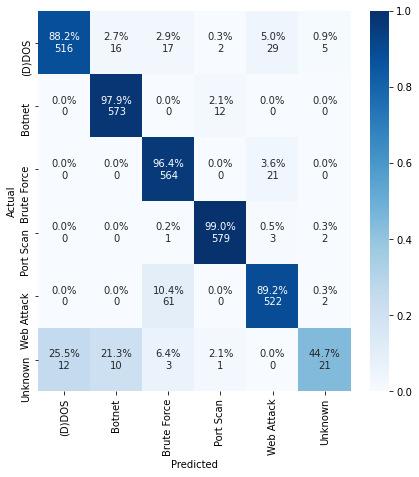

In [280]:
classes = ['(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Web Attack', 'Unknown']
fig = util.plot_confusion_matrix(y_test, y_pred, values=classes, labels=classes)

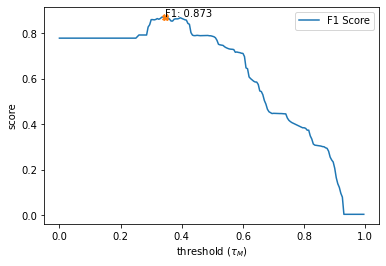

In [281]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(thresholds, fscore, label="F1 Score")
plt.plot(thresholdOpt, fscoreOpt, marker="X")
plt.annotate(f"F1: {str(round(fscoreOpt, 3))}", (thresholdOpt, fscoreOpt))
plt.xlabel(r"threshold ($\tau_M$)")
plt.ylabel("score")
plt.legend()